<a href="https://colab.research.google.com/github/LeechXDD/9417_Pro_Project/blob/main/feature_engineer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [3]:
!pip install tensorflow_addons
!pip install tensorflow
!pip install tensorflow --upgrade
!pip install --upgrade tensorflow-addons
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.7 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benedictachun","key":"a3f94529fc258924b3388f08d1efba16"}'}

In [6]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [7]:
!kaggle competitions download -c predict-student-performance-from-game-play
! kaggle datasets list

 98% 953M/968M [00:05<00:00, 93.5MB/s]
100% 968M/968M [00:06<00:00, 168MB/s] 
ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset          Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           4934        205  1.0              
nelgiriyewithana/countries-of-the-world-2023                      Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           3748        143  1.0              
arnavsmayan/netflix-userbase-dataset                              Netflix Userbase Dataset                             25KB  2023-07-04 07:38:41           4954   

In [8]:
! mkdir kaggleData
! unzip predict-student-performance-from-game-play.zip -d kaggleData

from google.colab import drive
drive.mount('/content/drive')

Archive:  predict-student-performance-from-game-play.zip
  inflating: kaggleData/jo_wilder/__init__.py  
  inflating: kaggleData/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: kaggleData/jo_wilder_310/__init__.py  
  inflating: kaggleData/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: kaggleData/sample_submission.csv  
  inflating: kaggleData/test.csv     
  inflating: kaggleData/train.csv    
  inflating: kaggleData/train_labels.csv  
Mounted at /content/drive


In [9]:
def get_minimal_dtype(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df

In [10]:
train_data = pd.read_csv('kaggleData/train.csv')
test_data = pd.read_csv('kaggleData/test.csv')

In [11]:
train_data = get_minimal_dtype(train_data)

Memory usage of dataframe is 4012.60 MB
Memory usage became:  1028.2593326568604  MB


In [12]:
# Load in labels for training dataset
labels = pd.read_csv('kaggleData/train_labels.csv')
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


#### Data Cleaning
The columns with missing values are:

- page: This is only for notebook-related events. The missing values could indicate that the event is not related to the notebook. We could fill missing values with a placeholder like -1 to denote 'Not Applicable'.
- room_coor_x, room_coor_y, screen_coor_x, screen_coor_y: These are the coordinates of the click, and are only relevant for click events. Similar to 'page', we could fill missing values with a placeholder.
- hover_duration: This is only for hover events. We can use the same approach as for the coordinates.
- text, fqid, text_fqid: These columns contain information about the event and the room. Missing values could indicate that the event does not involve any text or specific interactions that would be recorded in these fields. We could replace missing values with a placeholder like 'None' or 'Not Applicable'.

In [13]:
# Find out columns with missing values
missing_values = train_data.isnull().sum()

# Fill missing values
train_data['page'].fillna(-1, inplace=True)
train_data['room_coor_x'].fillna(-1, inplace=True)
train_data['room_coor_y'].fillna(-1, inplace=True)
train_data['screen_coor_x'].fillna(-1, inplace=True)
train_data['screen_coor_y'].fillna(-1, inplace=True)
train_data['hover_duration'].fillna(-1, inplace=True)

### Exploratory Data Analysis

In [14]:
# Set plot style
sns.set_style("whitegrid")

# Create a function for easy plotting
def plot_count(train_data, column, title, color, rotation=0):
    plt.figure(figsize=(12,6))
    sns.countplot(data=train_data, x=column, order=train_data[column].value_counts().index, color=color)
    plt.title(title, size=16)
    plt.xticks(rotation=rotation)
    plt.show()

#### Distribution of the Event Names
The most common event in the dataset is 'navigate_click', followed by 'notification_click'. These events likely relate to key interactions within the game and could be influential in a model's ability to predict student performance.

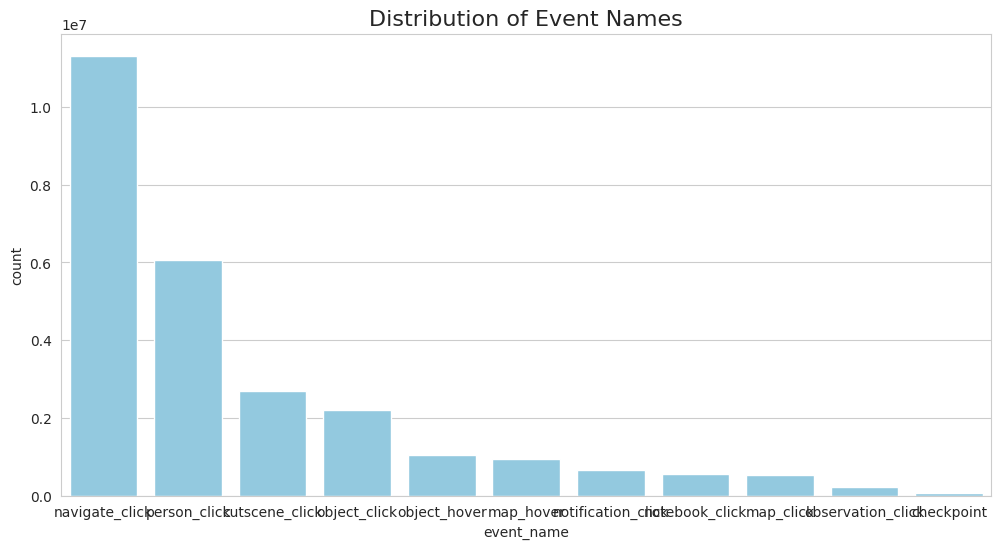

In [15]:
# Plot the distribution of event names
plot_count(train_data, 'event_name', 'Distribution of Event Names', 'skyblue')

#### Distribution of Game Levels
The distribution of game levels shows that the majority of the events are happening in the middle levels of the game (around level 10). This could suggest that most users progress to these levels before stopping, or that these levels simply have more interactive events.

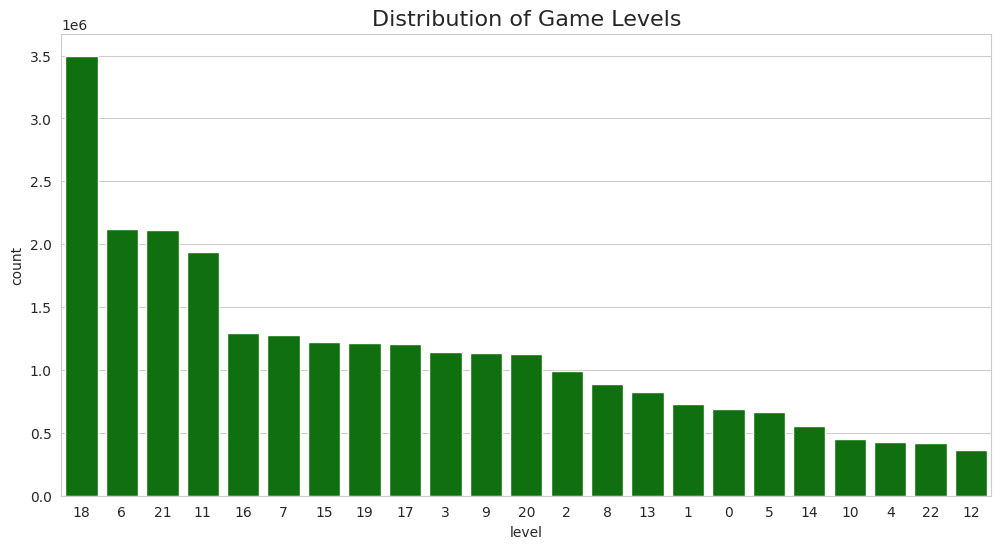

In [16]:
# Plot the distribution of levels
plot_count(train_data, 'level', 'Distribution of Game Levels', 'green')

#### Distribution of Level Groups
The level group distribution shows that the majority of events belong to the '5-12' level group. This is consistent with the distribution of game levels, as the majority of events occurred at these levels.

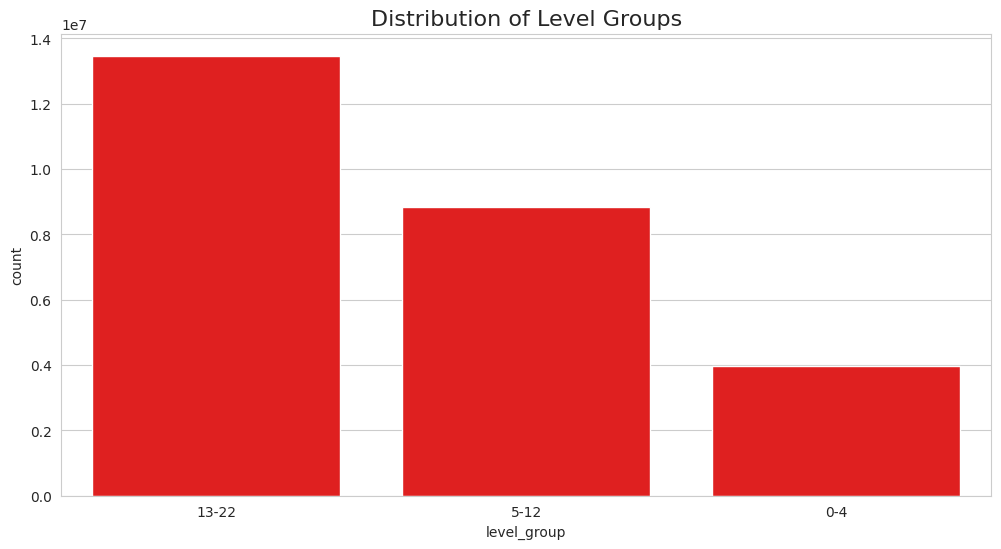

In [17]:
# Plot the distribution of level groups
plot_count(train_data, 'level_group', 'Distribution of Level Groups', 'red')

#### Elapsed Time Statistics
From the histogram of 'elapsed_time', we can observe that the distribution is heavily skewed to the right, with a few sessions having unusually high elapsed time values. These could potentially be outliers or errors in the data.

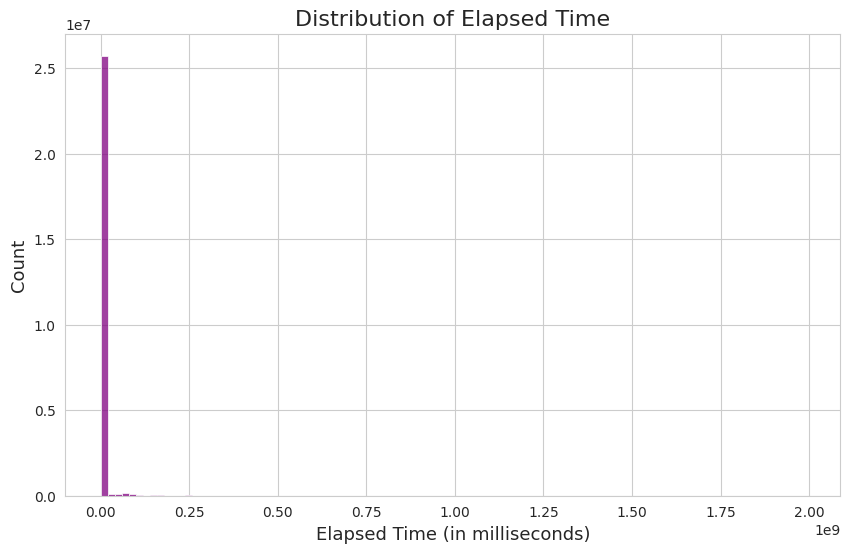

In [18]:
# Display statistics related to elapsed time
elapsed_time_stats = train_data['elapsed_time'].describe()
elapsed_time_stats

# Plot the distribution of 'elapsed_time'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['elapsed_time'], bins=100, color='purple')
plt.title('Distribution of Elapsed Time', size=16)
plt.xlabel('Elapsed Time (in milliseconds)', size=13)
plt.ylabel('Count', size=13)
plt.show()

From the table below it shows subset of the data that falls in the top 1% of 'elapsed_time' which could suggest outliers.

In [19]:
# Check the values on the high end of 'elapsed_time'
high_elapsed_time = train_data[train_data['elapsed_time'] > train_data['elapsed_time'].quantile(0.99)]
high_elapsed_time

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
62160,20100012562027690,412,122550441,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,31.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62161,20100012562027690,413,122551391,object_click,basic,9,-1.0,25.84375,-218.000000,473.0,548.0,-1.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62162,20100012562027690,414,122553183,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,1785.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62163,20100012562027690,415,122553580,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,734.0,NaN,reader.paper0.prev,tunic.library.microfiche,NaN,0,0,1,5-12
62164,20100012562027690,416,122558505,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,84.0,NaN,reader.paper0.prev,tunic.library.microfiche,NaN,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26288096,22100215032067016,984,85742264,map_hover,basic,22,-1.0,-1.00000,-1.000000,-1.0,-1.0,66.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288097,22100215032067016,985,85742848,map_hover,basic,22,-1.0,-1.00000,-1.000000,-1.0,-1.0,168.0,NaN,tunic.historicalsociety,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288098,22100215032067016,986,85743265,map_click,undefined,22,-1.0,511.75000,59.500000,474.0,293.0,-1.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288099,22100215032067016,987,85744579,navigate_click,undefined,22,-1.0,262.00000,4.882812,429.0,294.0,-1.0,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22


So I will set all 'elapsed_time' values above the 99th percentile to the 99th percentile value. This would limit the effect of extreme values without completely removing them from the dataset.

In [20]:
# Cap 'elapsed_time' at the 99th percentile
train_data['elapsed_time'] = train_data['elapsed_time'].clip(upper=train_data['elapsed_time'].quantile(0.99))

The maximum value is now significantly lower than before, while the other statistics (mean, standard deviation, etc.) remain similar. This means that the extreme high values have been limited, which should help to reduce their influence on the model.

In [21]:
# Verify the change
train_data['elapsed_time'].describe()

count    2.629695e+07
mean     2.734765e+06
std      9.689942e+06
min      0.000000e+00
25%      4.397000e+05
50%      1.014801e+06
75%      1.747040e+06
max      7.756060e+07
Name: elapsed_time, dtype: float64

### Feature Engineering

In [22]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df



### Improved version of feature engineering function

In [23]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Define feature engineering function
def feature_engineer_ver2(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df


In [24]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

from sklearn.preprocessing import PowerTransformer

def feature_engineer_ver3(dataset_df):
    dfs = []
    pt = PowerTransformer(method='yeo-johnson')

    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

        # Create dummy variables for top N most common events and names
        top_N = dataset_df[c].value_counts()[:10].index
        for val in top_N:
            dataset_df[c + '_' + val] = (dataset_df[c] == val).astype(int)
        tmp = dataset_df.groupby(['session_id','level_group']).agg({c + '_' + val: 'sum' for val in top_N})
        dfs.append(tmp)

    for c in NUMERICAL:
        # Fill missing values with the column median
        dataset_df[c].fillna(dataset_df[c].median(), inplace=True)

        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Normalize 'elapsed_time' column
        if c == 'elapsed_time':
            dataset_df[c] = pt.fit_transform(dataset_df[[c]])

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            #dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop').astype('category')

            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    return dataset_df



In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
             'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer_ver4(dataset_df):
    dfs = []
    le = LabelEncoder()
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

    for c in CATEGORICAL:
        # Label encoding for categorical features
        dataset_df[c+'_encoded'] = le.fit_transform(dataset_df[c].astype(str))
        tmp = dataset_df.groupby(['session_id','level_group'])[c+'_encoded'].agg(['mean', 'std'])
        tmp.columns = [c + '_encoded_mean', c + '_encoded_std']
        dfs.append(tmp)

    for c in NUMERICAL:
        # Fill missing values with the column median
        dataset_df[c].fillna(dataset_df[c].median(), inplace=True)

        # Calculate sum, mean and std for numerical features
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg(['sum', 'mean', 'std'])
        tmp.columns = [c + '_sum', c + '_mean', c + '_std']
        dfs.append(tmp)

        # Apply binning to numerical features
        dataset_df[c+'_binned'] = discretizer.fit_transform(dataset_df[[c]])
        tmp = dataset_df.groupby(['session_id','level_group'])[c+'_binned'].agg(['mean', 'std'])
        tmp.columns = [c + '_binned_mean', c + '_binned_std']
        dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['sum', 'mean', 'std'])
        tmp.columns = ['screen_coor_sum', 'screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg(['mean', 'std'])
        tmp.columns = ['total_hover_duration_mean', 'total_hover_duration_std']
        dfs.append(tmp)

    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    dataset_df['page_sum'] = dataset_df['page_sum'].astype('int32')
    for col in dataset_df.select_dtypes(include='float16').columns:
        dataset_df[col] = dataset_df[col].astype('float32')

    return dataset_df


### Test run on sample of dataset *****************

In [71]:
sample = train_data.sample(frac=0.05)
dataset_df = feature_engineer(sample)
#dataset_df = feature_engineer_ver2(sample)
#dataset_df = feature_engineer_ver3(sample)
#dataset_df = feature_engineer_ver4(sample)

#Also, remember to apply the same transformations to your test data.
#test_df = feature_engineer_ver4(test_data)

In [72]:
# Replace `inf` values:
dataset_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace `NaN` values with column mean:
dataset_df.fillna(dataset_df.mean(), inplace=True)


<ipython-input-72-0ee892e4a869>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_df.fillna(dataset_df.mean(), inplace=True)


### Trial Run on Model

In [28]:
!pip install tensorflow_addons
!pip install tensorflow_decision_forests
!pip install tensorflow
!pip install tensorflow --upgrade
!pip install keras --upgrade

import tensorflow as tf
import tensorflow_decision_forests as tfdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 79.0 MB/s eta 0:00:00


In [73]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


In [52]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [74]:

# Fetch the unique list of user sessions in the validation dataset. We assigned
# `session_id` as the index of our feature engineered dataset. Hence fetching
# the unique values in the index column will give us a list of users in the
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is:
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s.
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}


In [75]:

for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)


    # Filter the rows in the datasets based on the selected level group.
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]


    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model.
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings.
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.RandomForestModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])
    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]

    # Use the trained model to make predictions on the validation dataset and
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()

### q_no 1 grp 0-4


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 46ms/step
### q_no 2 grp 0-4


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 33ms/step
### q_no 3 grp 0-4


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 37ms/step
### q_no 4 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 45ms/step
### q_no 5 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 52ms/step
### q_no 6 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 41ms/step
### q_no 7 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 40ms/step
### q_no 8 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 50ms/step
### q_no 9 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 47ms/step
### q_no 10 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 46ms/step
### q_no 11 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 46ms/step
### q_no 12 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 41ms/step
### q_no 13 grp 5-12


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 43ms/step
### q_no 14 grp 13-22


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 48ms/step
### q_no 15 grp 13-22


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 53ms/step
### q_no 16 grp 13-22


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 42ms/step
### q_no 17 grp 13-22


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 40ms/step
### q_no 18 grp 13-22


<ipython-input-75-650d43caf6aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
<ipython-input-75-650d43caf6aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


5/5 [==============================] - 0s 39ms/step


In [76]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7312
question 2: accuracy 0.9756
question 3: accuracy 0.9351
question 4: accuracy 0.7938
question 5: accuracy 0.6045
question 6: accuracy 0.7895
question 7: accuracy 0.7462
question 8: accuracy 0.6338
question 9: accuracy 0.7630
question 10: accuracy 0.5843
question 11: accuracy 0.6565
question 12: accuracy 0.8701
question 13: accuracy 0.7155
question 14: accuracy 0.7324
question 15: accuracy 0.5754
question 16: accuracy 0.7494
question 17: accuracy 0.7036
question 18: accuracy 0.9516

Average accuracy 0.7506424321068658


In [77]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE


[("elapsed_time_std" (1; #2), 75.0),
 ("elapsed_time" (1; #1), 67.0),
 ("room_fqid_nunique" (1; #16), 58.0),
 ("page_std" (1; #11), 28.0),
 ("fqid_nunique" (1; #4), 27.0),
 ("event_name_nunique" (1; #3), 12.0),
 ("page" (1; #10), 12.0),
 ("room_coor_y_std" (1; #15), 10.0),
 ("screen_coor_x_std" (1; #18), 3.0),
 ("name_nunique" (1; #9), 2.0),
 ("screen_coor_y_std" (1; #20), 2.0),
 ("level" (1; #7), 1.0),
 ("room_coor_x" (1; #12), 1.0),
 ("screen_coor_x" (1; #17), 1.0),
 ("text_fqid_nunique" (1; #21), 1.0)]

In [78]:

true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with
# the highest `F1 score`.
# using uniform threashold = 0.5 for the baseline


# for threshold in np.arange(0.4,0.8,0.01):
#     metric = tf.keras.metrics.F1Score(average="macro",threshold=threshold)
#     y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
#     y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
#     metric.update_state(y_true, y_pred)
#     f1_score = metric.result().numpy()
#     if f1_score > max_score:
#         max_score = f1_score
#         best_threshold = threshold
metric = tf.keras.metrics.F1Score(average="macro",threshold=0.5)
y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
y_pred = tf.one_hot((prediction_df.values.reshape((-1))>0.5).astype('int'), depth=2)
metric.update_state(y_true, y_pred)
f1_score = metric.result().numpy()


print("threshold ", 0.5, "\tF1 score ", f1_score)

threshold  0.5 	F1 score  0.6151695
